# This Notebook will show how to run a model across a cluster using Azure Machine Learning Services

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.9.0


### Connect to your subscription

In [2]:
subscription_id = '6a0ec27b-1203-46fe-ade0-8c3003d5e4bc'
resource_group  = 'MLServiceWrokspace'
workspace_name  = 'MLServiceWrokspace'

try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print('Library configuration succeeded')
except:
    print('Workspace not found')


Library configuration succeeded


### We are going to try and create a model that will understand hand written digits

In [3]:
experiment_name = 'sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [4]:
#Check to see if there are any compute targets already set up in your subscription
ws.compute_targets

{'AmlComputeGPU': AmlCompute(workspace=Workspace.create(name='MLServiceWrokspace', subscription_id='6a0ec27b-1203-46fe-ade0-8c3003d5e4bc', resource_group='MLServiceWrokspace'), name=AmlComputeGPU, id=/subscriptions/6a0ec27b-1203-46fe-ade0-8c3003d5e4bc/resourceGroups/MLServiceWrokspace/providers/Microsoft.MachineLearningServices/workspaces/MLServiceWrokspace/computes/AmlComputeGPU, type=AmlCompute, provisioning_state=Succeeded, location=northeurope, tags=None),
 'alwayson': AmlCompute(workspace=Workspace.create(name='MLServiceWrokspace', subscription_id='6a0ec27b-1203-46fe-ade0-8c3003d5e4bc', resource_group='MLServiceWrokspace'), name=alwayson, id=/subscriptions/6a0ec27b-1203-46fe-ade0-8c3003d5e4bc/resourceGroups/MLServiceWrokspace/providers/Microsoft.MachineLearningServices/workspaces/MLServiceWrokspace/computes/alwayson, type=AmlCompute, provisioning_state=Succeeded, location=northeurope, tags=None),
 'automlcluster': AmlCompute(workspace=Workspace.create(name='MLServiceWrokspace', su

### We are going to create a new compute target if one does not exist (using GPUs for the DNN training)

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
AmlCompute_cluster_name = "AmlComputeGPU"
cluster_min_nodes = 0
cluster_max_nodes = 4
vm_size = "STANDARD_NC6"
autoscale_enabled = True


if AmlCompute_cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[AmlCompute_cluster_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + AmlCompute_cluster_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, # NC6 is GPU-enabled
                                                                vm_priority = 'lowpriority', # optional Low Priority VMs use Azure's excess capacity and are thus cheaper but risk your run being pre-empted.
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes,
                                                                idle_seconds_before_scaledown=120)
    
    # create the cluster
    compute_target = ComputeTarget.create(ws, AmlCompute_cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())

found compute target. just use it. AmlComputeGPU


# Download the MNIST dataset (handwritten digit database)
Download the MNIST dataset and save the files into a data directory locally. Images and labels for both training and testing are downloaded.

In [6]:
import os
import urllib.request

os.makedirs('./dataMNIST', exist_ok = True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename='./dataMNIST/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename='./dataMNIST/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename='./dataMNIST/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename='./dataMNIST/test-labels.gz')

('./dataMNIST/test-labels.gz', <http.client.HTTPMessage at 0x7f2d3047cdd8>)

# Display some sample images

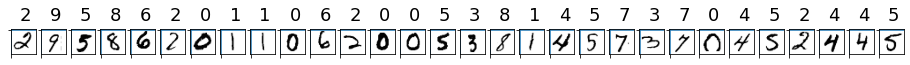

CPU times: user 2.75 s, sys: 938 ms, total: 3.68 s
Wall time: 2.4 s


In [7]:
%%time
# make sure utils.py is in the same directory as this code
from utils import load_data

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data('./dataMNIST/train-images.gz', False) / 255.0
y_train = load_data('./dataMNIST/train-labels.gz', True).reshape(-1)

X_test = load_data('./dataMNIST/test-images.gz', False) / 255.0
y_test = load_data('./dataMNIST/test-labels.gz', True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [8]:
%%time
#Upload to the cloud datastore
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir='./dataMNIST', target_path='mnist', overwrite=True, show_progress=True)

AzureBlob mlservicewroks0608373343 azureml-blobstore-b77f06f9-80dd-4231-9153-6a77c47edd72
Uploading an estimated of 4 files
Uploading ./dataMNIST/test-images.gz
Uploading ./dataMNIST/test-labels.gz
Uploading ./dataMNIST/train-images.gz
Uploading ./dataMNIST/train-labels.gz
Uploaded ./dataMNIST/test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./dataMNIST/train-labels.gz, 2 files out of an estimated total of 4
Uploaded ./dataMNIST/test-images.gz, 3 files out of an estimated total of 4
Uploaded ./dataMNIST/train-images.gz, 4 files out of an estimated total of 4
Uploaded 4 files
CPU times: user 95.6 ms, sys: 43.9 ms, total: 140 ms
Wall time: 1.14 s


$AZUREML_DATAREFERENCE_98458661eea349419f3f0a38245f2b1b

# Train in the notebook

In [9]:
%%time
#Train a local model - this will take a while 5 to 10mins
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 1min 37s, sys: 153 ms, total: 1min 37s
Wall time: 1min 39s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
y_hat = clf.predict(X_test)
print(np.average(y_hat == y_test))

0.9201


# Train on a remote cluster


In [11]:
#Create a directory
import os
script_folder = './sklearn-mnist'
os.makedirs(script_folder, exist_ok=True)

# Create a training script

In [12]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
#from sklearn.externals import joblib
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = os.path.join(args.data_folder, 'mnist')
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularizaion rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Overwriting ./sklearn-mnist/train.py


In [13]:
#Copy acorss utils python packege as well
import shutil
shutil.copy('utils.py', script_folder)

'./sklearn-mnist/utils.py'

In [14]:
#An estimator object is used to submit the run. 
#Define the data folder and the learning rate
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.8
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                use_gpu=True,
                entry_script='train.py',
                conda_packages=['scikit-learn'])



In [15]:
#Run the job on the cluster
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
sklearn-mnist,sklearn-mnist_1600418558_0ba7c03e,azureml.scriptrun,Queued,Link to Azure Machine Learning studio,Link to Documentation


In [16]:
#Monitor the job in the cluster
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

# Hyerparameter Training

In [17]:
#Train Hyperparameters
from azureml.train.hyperdrive import *

ps = RandomParameterSampling(
    {
        '--regularization': uniform(0.001, 0.9)
    }
)


In [18]:
htc = HyperDriveConfig(estimator=est, 
                          hyperparameter_sampling=ps, 
                          primary_metric_name='accuracy', 
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=4,
                          max_concurrent_runs=4)

In [19]:
htr = exp.submit(config=htc)

The same input parameter(s) are specified in estimator/run_config script params and HyperDrive parameter space. HyperDrive parameter space definition will override these duplicate entries. ['--regularization'] is the list of overridden parameter(s).


In [20]:
RunDetails(htr).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…